In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cairo
import tensorflow as tf
from tensorflow import keras

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pickle
from keras.layers import Dense, GlobalAveragePooling2D
import sys
import numpy as np
import glob as glob
from keras import optimizers
import os
from mlxtend.plotting import plot_confusion_matrix
import random
from PIL import Image
from contextlib import redirect_stdout
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [3]:
image_width, image_height = 200, 200
epochs = 50
image_size = (image_width, image_height)
sample_per_epoch = 10000
number_of_validation_sample = 2000
batch_size = 8
test_size = 30
input_shape = (image_width, image_height, 3)
file_path_train = r"/home/ronaldsonbellande/Desktop/Robotic Vision/color_cube_detector_classification/create_model_from_cubes/"
file_path_validation = r"/home/ronaldsonbellande/Desktop/Robotic Vision/color_cube_detector_classification/validation_2/"
file_path_test = r"/home/ronaldsonbellande/Desktop/Robotic Vision/color_cube_detector_classification/testing_image_cubes/"

In [4]:
training_dataset = keras.preprocessing.image_dataset_from_directory(
    file_path_train,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    file_path_validation,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

test_dataset = keras.preprocessing.image_dataset_from_directory(
    file_path_test,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

test_data_image_classification = ImageDataGenerator(rescale = 1./255,
                                                        rotation_range = 20,
                                                        width_shift_range = 0.2,
                                                        height_shift_range = 0.2,
                                                        shear_range = 0.2,
                                                        zoom_range = 0.2,
                                                        fill_mode = 'nearest',
                                                        horizontal_flip = True)

test_generator = test_data_image_classification.flow_from_directory(file_path_test,
    target_size=(image_width, image_height),
    batch_size=batch_size, class_mode="binary")

Found 636 files belonging to 3 classes.
Found 31 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 60 images belonging to 3 classes.


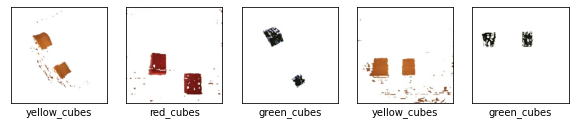

In [5]:
class_name = training_dataset.class_names

fig,ax = plt.subplots(1,5,figsize=(10,10))
ax = ax.flat

for images,labels in training_dataset.take(1):
    for i in range(5):
        ax[i].imshow(images[i].numpy().astype('uint8'))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlabel(class_name[labels[i]])
plt.show()

In [6]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2)
],name="data_augmentation")

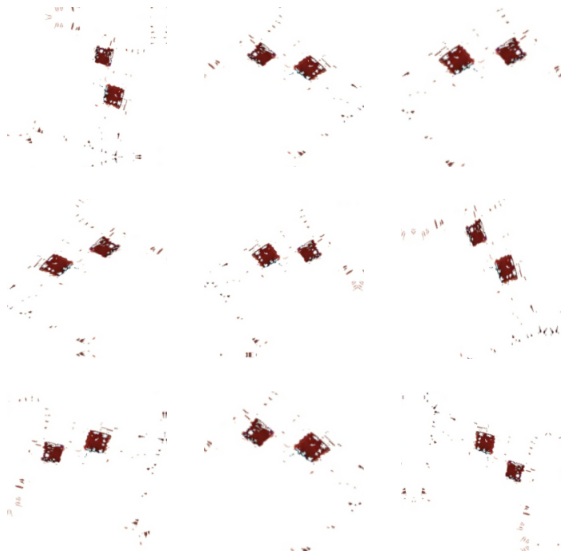

In [7]:
for image, temp in training_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
# Transfer Learning
base_model = keras.applications.Xception(include_top=False,input_shape=image_size+(3,))
base_model.trainable = False

inputs = layers.Input(shape=input_shape)
first_model = data_augmentation(inputs)
first_model = layers.experimental.preprocessing.Rescaling(1./255)(first_model)  # normalized
first_model = base_model(first_model, training=False)
first_model = layers.GlobalAveragePooling2D()(first_model)
first_model = layers.Dropout(0.3)(first_model)
first_model = layers.Dense(24)(first_model)
first_model = layers.Dropout(0.2)(first_model)
outputs = layers.Dense(3)(first_model)

model = keras.Model(inputs, outputs)

In [9]:
base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.Adam(lr=base_learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [10]:
model_summary = model.summary()
with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                49176 

In [11]:
model.evaluate(test_dataset)

8/8 [==============================] - 30s 3s/step - loss: 1.1001 - accuracy: 0.3487


[1.0267704725265503, 0.4166666567325592]

In [12]:
checkpoint = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                        mode='max',restore_best_weights=True,patience=10)

trained_model= model.fit(training_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint])

Epoch 1/50
80/80 [==============================] - 570s 7s/step - loss: 0.8151 - accuracy: 0.6714 - val_loss: 0.6545 - val_accuracy: 0.7097
Epoch 2/50
80/80 [==============================] - 286s 4s/step - loss: 0.4547 - accuracy: 0.8506 - val_loss: 0.6440 - val_accuracy: 0.7097
Epoch 3/50
80/80 [==============================] - 309s 4s/step - loss: 0.3247 - accuracy: 0.9214 - val_loss: 0.6426 - val_accuracy: 0.7097
Epoch 4/50
80/80 [==============================] - 324s 4s/step - loss: 0.2737 - accuracy: 0.9230 - val_loss: 0.6378 - val_accuracy: 0.7419
Epoch 5/50
80/80 [==============================] - 384s 5s/step - loss: 0.1983 - accuracy: 0.9497 - val_loss: 0.6708 - val_accuracy: 0.7419
Epoch 6/50
80/80 [==============================] - 348s 4s/step - loss: 0.2053 - accuracy: 0.9245 - val_loss: 0.7110 - val_accuracy: 0.7419
Epoch 7/50
80/80 [==============================] - 313s 4s/step - loss: 0.1647 - accuracy: 0.9591 - val_loss: 0.7576 - val_accuracy: 0.7419
Epoch 8/50
80

In [13]:
model.evaluate(test_dataset)

8/8 [==============================] - 16s 2s/step - loss: 0.7767 - accuracy: 0.6000


[0.7767160534858704, 0.6000000238418579]

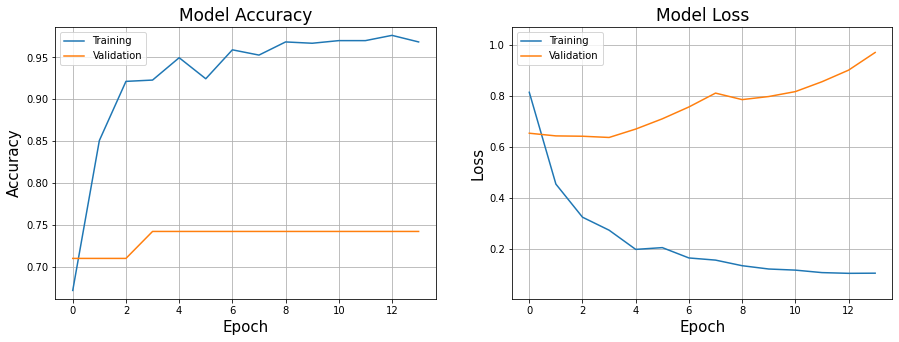

In [14]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']
ylim_pad = [0.01, 0.1]
plt.figure(figsize=(15, 5))
y1 = trained_model.history['accuracy']
y2 = trained_model.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)
plt.plot(y1)
plt.plot(y2)
plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
    
y1 = trained_model.history['loss']
y2 = trained_model.history['val_loss']
min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
plt.subplot(122)
plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()                      
plt.show()

results
8/8 - 10s - loss: 0.7767 - accuracy: 0.6000
Loss     : 0.78  
Accuracy : 60.00%
8/8 [==============================] - 13s 2s/step
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 38.96%
Recall        : 35.00%
F1-Score      : 34.64%
------------------------------------------------------------------------------------------





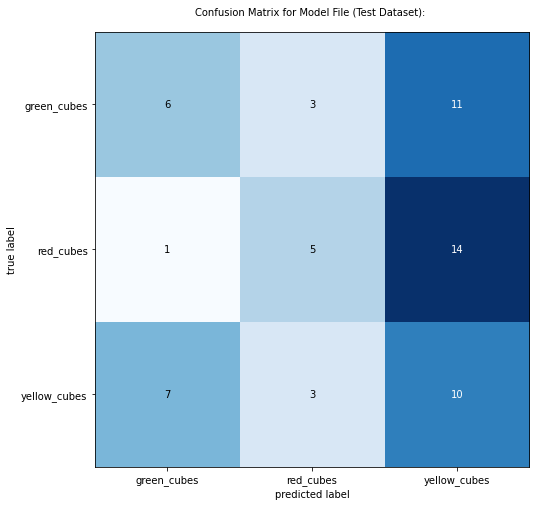




------------------------------------------------------------------------------------------
Report for Model File:  
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 green_cubes       0.43      0.30      0.35        20
   red_cubes       0.45      0.25      0.32        20
yellow_cubes       0.29      0.50      0.36        20

    accuracy                           0.35        60
   macro avg       0.39      0.35      0.35        60
weighted avg       0.39      0.35      0.35        60

------------------------------------------------------------------------------------------


In [16]:
classes = test_generator.class_indices
print("results")
result  = model.evaluate(test_dataset, steps=len(test_dataset), verbose=2)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))
y_pred = model.predict(test_dataset, steps=len(test_dataset), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

image_file_name = "/home/ronaldsonbellande/Desktop/Robotic Vision/color_cube_detector_classification/image_test1.png"

file_path = 'CNN_cube_detector_created.h5'
title = file_path.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred, average="weighted") 
recall = recall_score(y_true, y_pred, average="weighted") 
f1 = f1_score(y_true, y_pred, average="weighted") 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true*10, y_pred*10)
fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(10,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=10)
plt.yticks(range(len(classes)), classes, fontsize=10)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=10)
fig.savefig(image_file_name, dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [17]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print(y_pred_batch)

sizeofbatch = (y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", (y_pred_batch[1])))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)


def show_predictions(test_generator, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    image_file_name = "/home/ronaldsonbellande/Desktop/Robotic Vision/color_cube_detector_classification/"
    file_names = test_generator.filenames
    
    m = {}
    length = len(y_true)

    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = plt.imread(file_path_test+"//"+ file_names[num])
        plt.imshow(img, aspect='auto')

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')  

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])
    
    plt.tight_layout()
    plt.savefig('small_prediction_newdata1.png',dpi=500)
    plt.show()
    
def reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

def subplot(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

[0 0 0 0]
-----------------------------------
Selected Batch No       : 7
-----------------------------------
Batch Size              : 0
-----------------------------------
Accuracy                : 35.00%
-----------------------------------


In [18]:
def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs

image_file_name_batch = "/result.png"
image_file_name_sample = "/sample.png"

batch_size_t = (y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}

dpi=100

ncols = 9
nrows = 3

count = ncols*nrows

subplot_params = subplot(nrows, ncols, dpi)
plot_params = reset_plot_params()

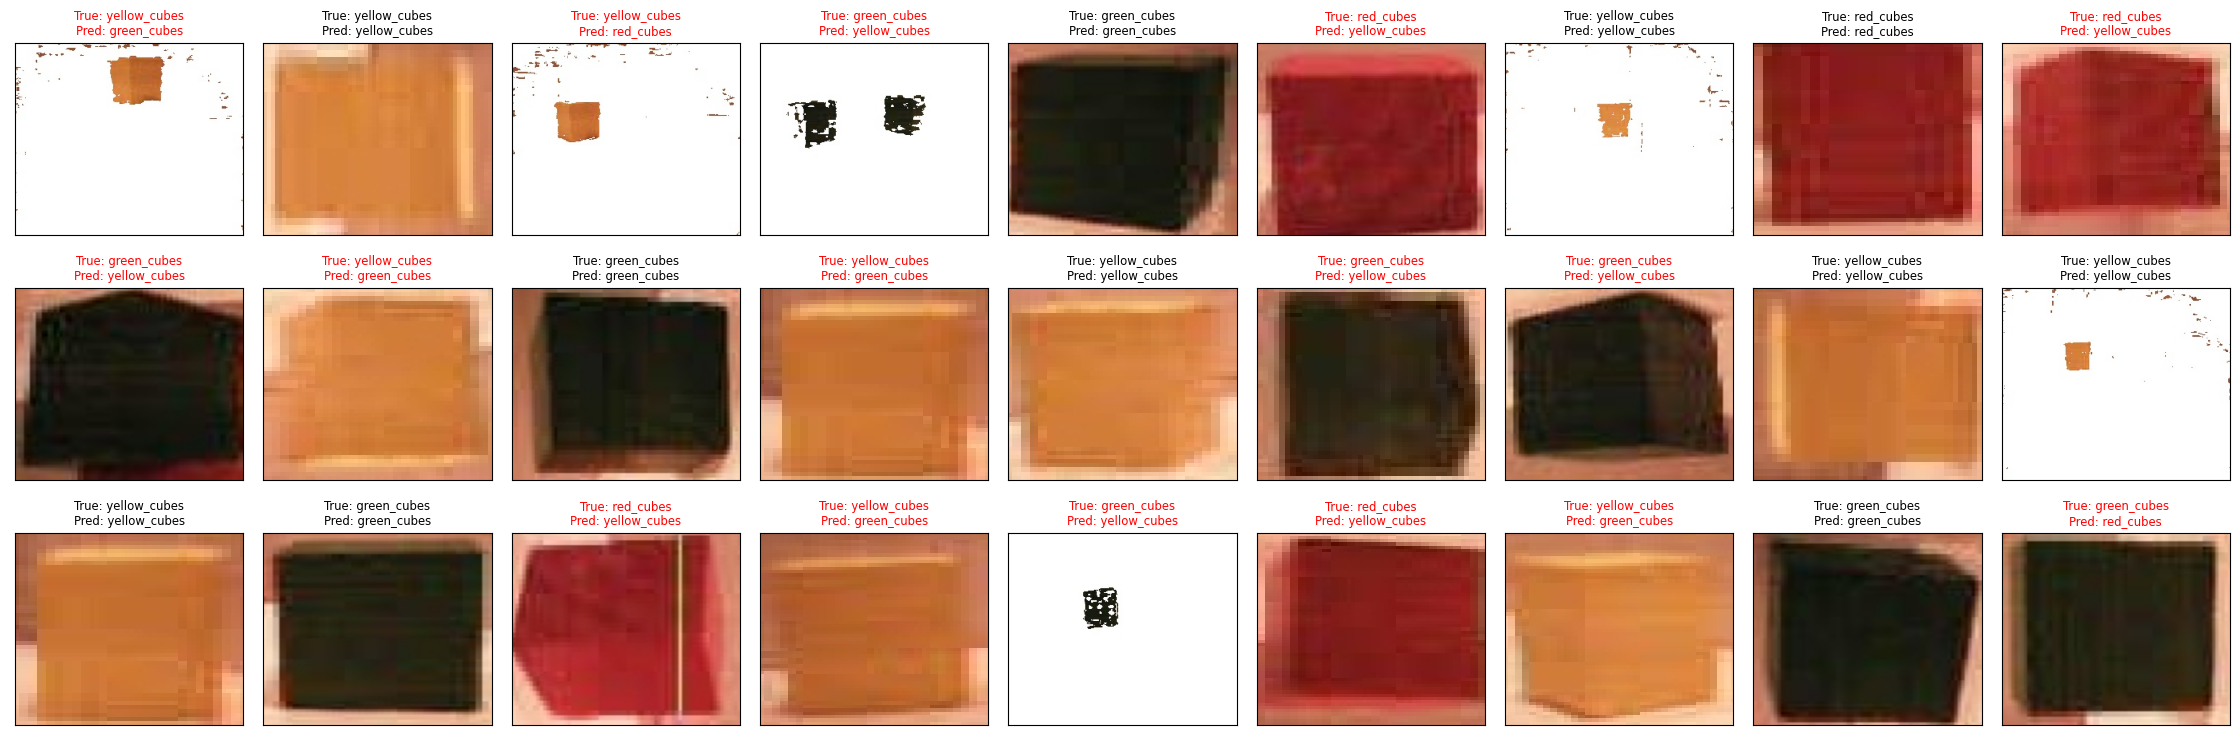

In [19]:
show_predictions(test_generator, y_true, y_pred, subplot_params, plot_params, class_map, file_path_test, image_file_name_batch, count=count, sample=True)

In [20]:
for layer in base_model.layers[:80]:
    layer.trainable =  True

model.compile(
    optimizer=keras.optimizers.Adam(lr=base_learning_rate/3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model_summary = model.summary()
with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

checkpoint = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                        mode='max',restore_best_weights=True,patience=10)

trained_model= model.fit(training_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                49176 

In [21]:
model.save_weights("CNN_cube_detector_created.h5")

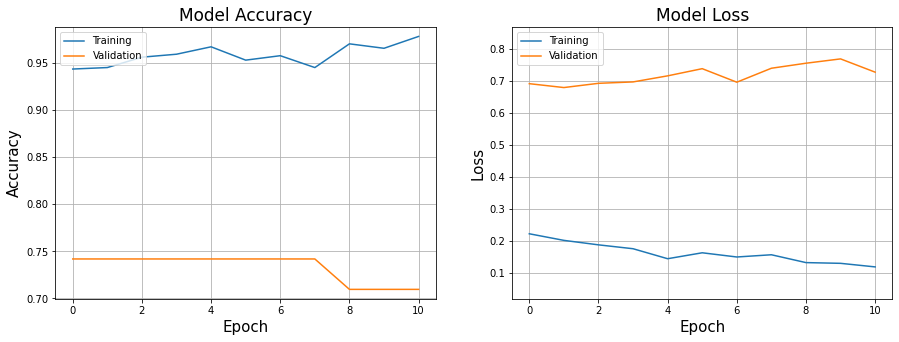

In [22]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']
ylim_pad = [0.01, 0.1]
plt.figure(figsize=(15, 5))
y1 = trained_model.history['accuracy']
y2 = trained_model.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)
plt.plot(y1)
plt.plot(y2)
plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
    
y1 = trained_model.history['loss']
y2 = trained_model.history['val_loss']
min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
plt.subplot(122)
plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()                      
plt.show()

In [23]:
classes = test_generator.class_indices

In [24]:
print("results")
result  = model.evaluate(test_dataset, steps=len(test_dataset), verbose=2)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
8/8 - 10s - loss: 0.8452 - accuracy: 0.6000
Loss     : 0.85  
Accuracy : 60.00%


In [25]:
y_pred = model.predict(test_dataset, steps=len(test_dataset), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes
print(y_true)

8/8 [==============================] - 16s 2s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 16.43%
Recall        : 20.00%
F1-Score      : 16.86%
------------------------------------------------------------------------------------------





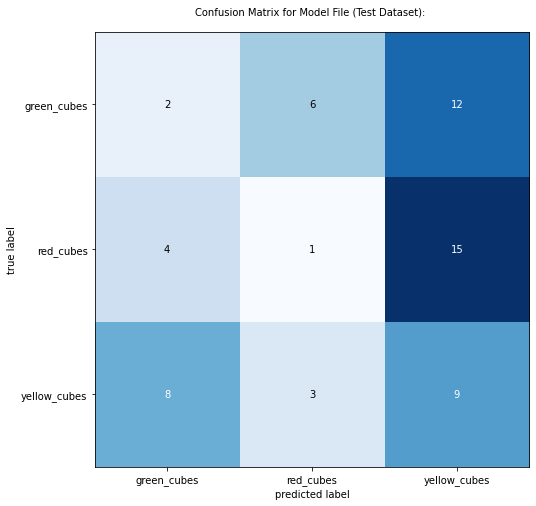




------------------------------------------------------------------------------------------
Report for Model File:  
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 green_cubes       0.14      0.10      0.12        20
   red_cubes       0.10      0.05      0.07        20
yellow_cubes       0.25      0.45      0.32        20

    accuracy                           0.20        60
   macro avg       0.16      0.20      0.17        60
weighted avg       0.16      0.20      0.17        60

------------------------------------------------------------------------------------------


In [26]:
image_file_name = "/home/ronaldsonbellande/Desktop/Robotic Vision/color_cube_detector_classification/"

file_path = 'CNN_cube_detector_created.h5'
title = file_path.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred, average="weighted") 
recall = recall_score(y_true, y_pred, average="weighted") 
f1 = f1_score(y_true, y_pred, average="weighted") 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true*10, y_pred*10)
fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(10,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=10)
plt.yticks(range(len(classes)), classes, fontsize=10)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=10)
fig.savefig(image_file_name, dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [27]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print(y_pred_batch)

sizeofbatch = (y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", (y_pred_batch[1])))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

[0 0 0 0 0 0 0 0]
-----------------------------------
Selected Batch No       : 4
-----------------------------------
Batch Size              : 0
-----------------------------------
Accuracy                : 20.00%
-----------------------------------


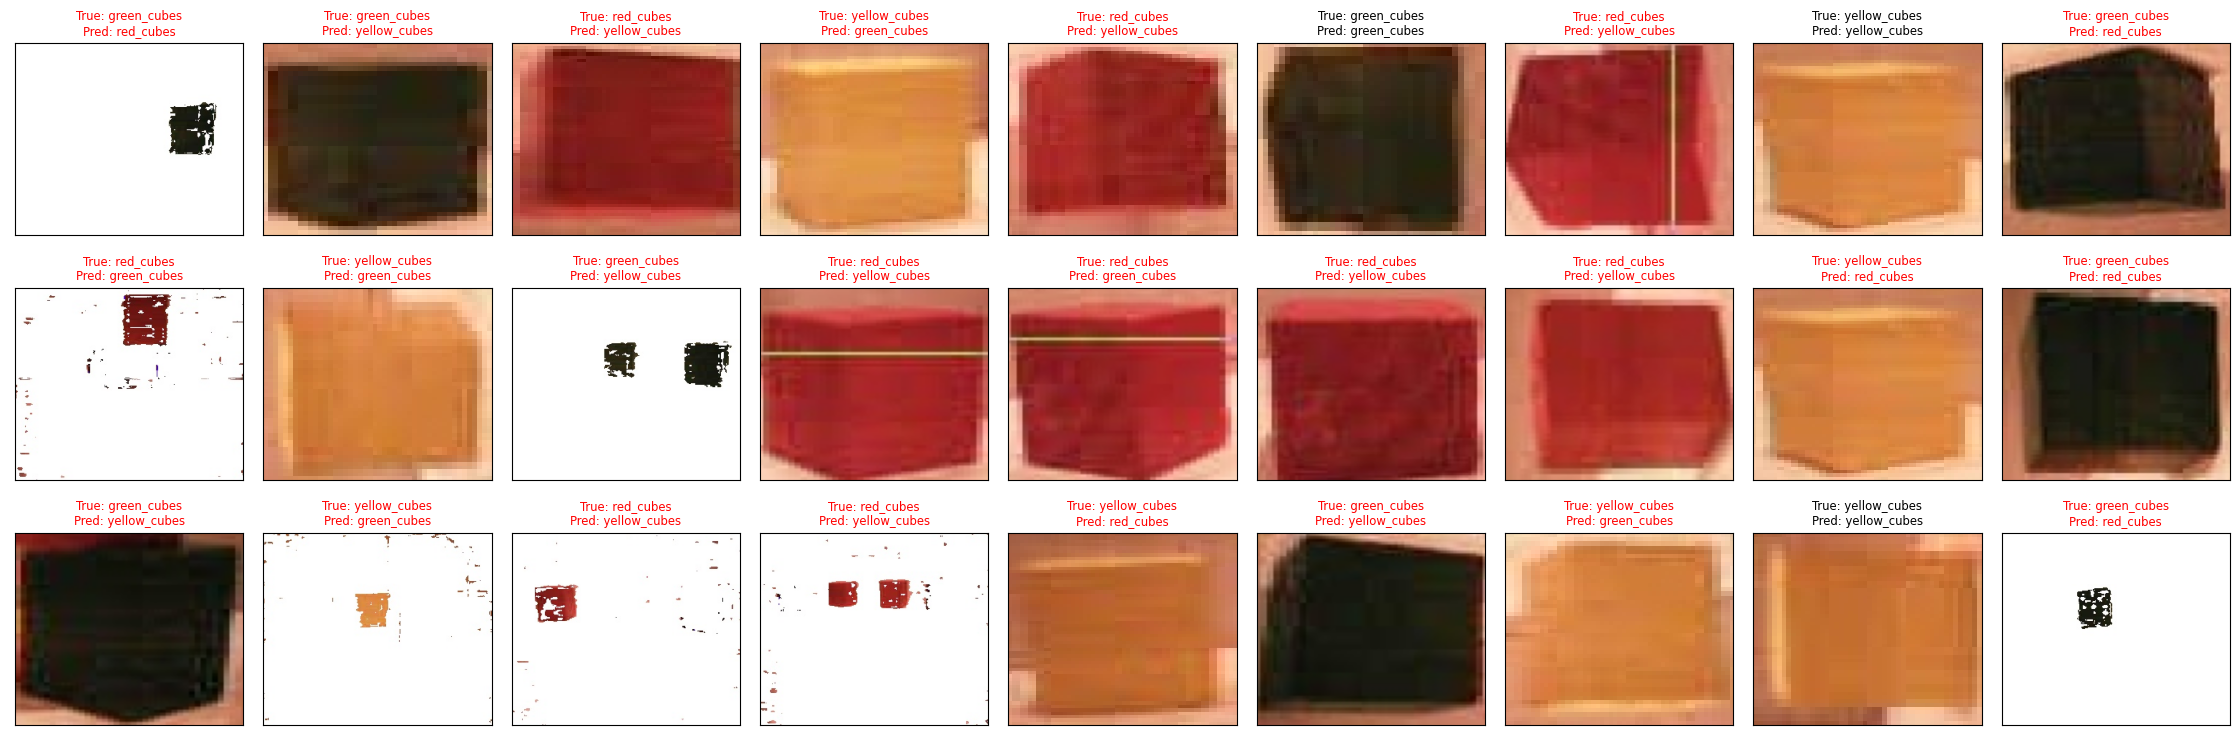

In [28]:
show_predictions(test_generator, y_true, y_pred, subplot_params, plot_params, class_map, file_path_test, image_file_name_batch, count=count, sample=True)